/home/diallo/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


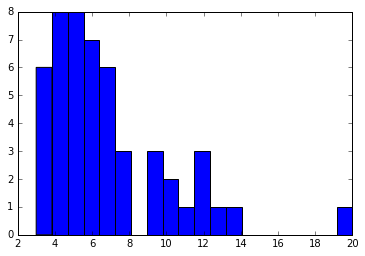

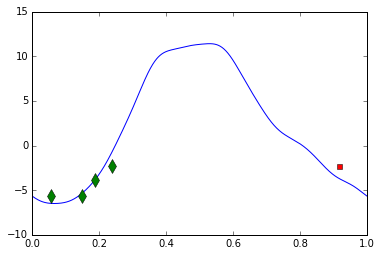

In [2]:
from Classes import * 
from Simu import *
from NLL import *
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import sympy as sy
from scipy import linalg
import pylab as pl
import math as ma
import time 
%matplotlib inline
b=Base(np.array([1,4])).val(np.array([1,2]))

N=10
D=5
n_t_moy=10
varu1=5
varu2=2


# Simulation des temps 
(T,L,M_nt)=temps(N,D,n_t_moy)
(U,V1,V2)=X_Params(varu1,varu2,N,D)
vec=np.reshape(M_nt,(N*D,1))

fig1 = plt.figure().add_subplot(111)
fig1.hist(vec,bins=20)


# Exemple de signe vital simulé
t=np.linspace(0,1,1000)
X=X_fonc(t,U[0,0],V1[0,0,:],V2[0,0,:])

fig2 = plt.figure().add_subplot(111)
fig2.plot(t,X.val())

#plt.savefig("Ftraj.png")
Xdata=X_obs(U,V1,V2,L)
fig2.plot(L[0][0],Xdata[0][0],marker="d",markersize=10,linestyle="none")
fig2.plot(T[0],Xdata[0][0][len(Xdata[0][0])-1],marker="s",markersize=5,color="r")
#plt.savefig("Xobs.png")

In [4]:
class NLL_nocens:
    def __init__(self,Alpha,Beta,Sigma,k,moy,Psi,J=50):
        self.N=len(Psi)
        self.D=len(Psi[0])
        self.Alpha=Alpha
        self.Beta=Beta
        self.k=k
        self.moy=moy
        self.Psi=Psi
        self.J=J
        self.Sigma=Sigma
    def val(self,Z,t,T,X,Y):
        I1=KBeta(t,T,self.k,self.Beta,self.J).val()
        I2=kbb(T,self.k,self.Beta,self.J).val()
        KBPsi=[ [ [] for j in range(self.D) ] for i in range(self.N)]
        EY=np.zeros(self.N,float)
        EYF=np.zeros((N,D),float)
        VYF=np.zeros((N,D),float)
        for i in range(self.N):
            for j in range(self.D):
                m=len(X[i][j])
                KBPsi[i][j]=I1[i][j].dot(Psi[i][j])
                EYF[i,j]=KBPsi[i][j].dot( X[i][j]- np.ones(m,float)*self.moy[i,j] )
                VYF[i,j]=KBPsi[i][j].dot(I1[i][j])
            Un=np.ones(self.J+1,float)
            Un[0]=0.5
            Un[self.J]=0.5
            # On calcule l'espérance de Y sachant X avec l'espérance de Y et le terme de conditionnement gaussien
            EY[i]= Z.dot(Alpha) + ( np.sum( Un.dot(Beta[i,:]) * self.moy[i,:] ) /self.J ) + np.sum( EYF[i,:] ) / T[i]
            # On calcule la variance de Y sachant X avec le terme de variance issu des VFT X^i_j et de l'erreur résiduelle 
            VY[i]= np.sum( np.asarray(I2[i]) - VYF[i,:] ) / (T[i]**2) + Sigma**2 
        # On peut alors calculer la vraisemblance
        #NLL = np.sum( (Y-EY)**2/VY + np.log(VY) )
        return (EY,VY);

In [12]:
Kbeta=2

s=sy.Symbol('s')
t=sy.Symbol('t')
syPhi=sy.ones(Kbeta**2,1)
syb=sy.ones(1,Kbeta*Kbeta)
k=0
for i in range(Kbeta):
    for j in range(Kbeta):
        syPhi[k]=(s**i)*(t**j) 
        syb[k]=sy.Symbol('b'+str(k))
        k+=1
syPhi_mat=syPhi*(syPhi.T)
sy.pprint(syPhi_mat)

syPhi_mat_dsds=syPhi_mat.diff(s,s)
sy.pprint(syPhi_mat_dsds)

syPhi_mat_dsdt=syPhi_mat.diff(s,t)
sy.pprint(syPhi_mat_dsdt)

syPhi_mat_dtdt=syPhi_mat.diff(t,t)
sy.pprint(syPhi_mat_dtdt)


syBeta=syb*syPhi
sy.pprint(syBeta)
# Disons que tous les coefs valent 1
coefs=np.ones(Kbeta**2,float)
replacements=[ (sy.sympify('b'+str(i)),coefs[i]) for i in range(Kbeta**2)]
replacements.append((T,1.))
print replacements
syBeta_subs=syBeta.subs(replacements)[0]
print syBeta_subs
betaf=sy.lambdify(t,syBeta_subs,'numpy')
betaf(1)

⎡ 1    t     s     s⋅t ⎤
⎢                      ⎥
⎢       2            2 ⎥
⎢ t    t    s⋅t   s⋅t  ⎥
⎢                      ⎥
⎢             2    2   ⎥
⎢ s   s⋅t    s    s ⋅t ⎥
⎢                      ⎥
⎢        2   2     2  2⎥
⎣s⋅t  s⋅t   s ⋅t  s ⋅t ⎦
⎡0  0   0    0  ⎤
⎢               ⎥
⎢0  0   0    0  ⎥
⎢               ⎥
⎢0  0   2   2⋅t ⎥
⎢               ⎥
⎢              2⎥
⎣0  0  2⋅t  2⋅t ⎦
⎡0   0    0     1  ⎤
⎢                  ⎥
⎢0   0    1    2⋅t ⎥
⎢                  ⎥
⎢0   1    0    2⋅s ⎥
⎢                  ⎥
⎣1  2⋅t  2⋅s  4⋅s⋅t⎦
⎡0   0   0   0  ⎤
⎢               ⎥
⎢0   2   0  2⋅s ⎥
⎢               ⎥
⎢0   0   0   0  ⎥
⎢               ⎥
⎢              2⎥
⎣0  2⋅s  0  2⋅s ⎦
[b₀ + b₁⋅t + b₂⋅s + b₃⋅s⋅t]
[(b0, 1.0), (b1, 1.0), (b2, 1.0), (b3, 1.0), (T, 1.0)]
1.0*s*t + 1.0*s + 1.0*t + 1.0


2.0*s + 2.0

# Intro Sympy

In [ ]:
from sympy import *
import numpy as np

N=3
print "On peut définir une fonction d'un nombre indéterminé de variable par itération"
L=[ [] for i in range(N)]
f=0
for i in range(N):
    L[i]=Symbol('x'+ str(i+1) )
    f=f+(i+1)*L[i]
print f
print "Puis la différentier relativement à chacune"
print f.diff(L[N-1])
print "Pour obtenir le gradient, on utilisera plutôt la "

A=Matrix([[f,1],[0,1]])
A.diff(L[N-1])
print "On peut aussi définir des matrices bloc diagonale de taille indéterminée par itération"
liste=[[] for i in range(N)]
for i in range(N):
    liste[i]=A
B=Matrix()
for i in range(N):
    B=diag(B,A)
print B
A=B*ones(2*N,1)
print A